In [1]:
# Let's say we have a DataFrame

import pandas as pd
data = {"Salary": ["<=50K", "<=50K", ">=50K", ">=50K", ">=50K"], "Credit_score": ["Good", "Bad", "Bad", "Good", "Normal"], "Approval": [1, 0, 0, 1, 1]}
df = pd.DataFrame(data)
df

,Salary,Credit_score,Approval
0,<=50K,Good,1
1,<=50K,Bad,0
2,>=50K,Bad,0
3,>=50K,Good,1
4,>=50K,Normal,1


**Independent features**: Salary, Credit_score


**Dependent feature**: Approval

### Step 1:
* We will be constructing a base model
    * First we will calculate probability, i.e will be average of `Approval` distinct values:
        (0 + 1)/2 = 0.5 ; as we only have only two target classes
    * Now we need to calculate residuals: i.e  y-prob
    * This will be output of our base model

In [2]:
df["residual"] = df["Approval"] - 0.5
df

,Salary,Credit_score,Approval,residual
0,<=50K,Good,1,0.5
1,<=50K,Bad,0,-0.5
2,>=50K,Bad,0,-0.5
3,>=50K,Good,1,0.5
4,>=50K,Normal,1,0.5


### Step 2:
* We will contruct decision tree
* Let' say if we first take `Salary` column,
* Always remember: In XgBoost whenever we construct a tree, we always need to use binary classifier. Even if we have more than 2 classes, still we divide in that way so that leaf node will be 2, like here if we would have had 3 categories of Salary <=50K, >=50K & >=100K, so we will merge last two catgories here for constructing decision tree.

Here Salary is split into two:
Two children of Salary node will contains
* [0.5 -0.5 ]  (<=50K)
* [-0.5, 0.5, 0.5] (>=50K)

* Now we have to compute similarity weight
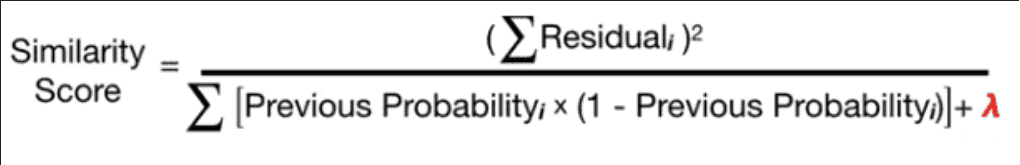

* We can assume λ = 0 for now, for making calculations easy(this is a hyperparamter)
* For left child(<=50K)
    * Similary weight: [0.5 + (-0.5)]^2 **/**  ( (0.5 * (1-0.5) + (0.5 * (1-0.5) )
    * In denominator we did for two time as we have to calculate for each point, also probability initially will be probability that was calculated before base model output
    * This will give us: 0 **/** (0.25 + 0.25) =  0
* For right child(>50K)
    * Similary weight: [-0.5 + 0.5 + 0.5]^2 / ( (0.5 * (1-0.5) + (0.5 * (1-0.5) (0.5 * (1-0.5) = 0.25/0.75  = 1/3
    
* For parent(i.e. Salary (for all points) )
    * [0.5 + -0.5 + -0.5 + 0.5 + 0.5]^2 / (0.25+0.25+0.25+0.25+0.25) = 0.25/1.25 = 0.2
    
* Now similarity score will be: 

        = left node similarity weight + right node similarity weight - Root similarity weight
        = 0 + 0.33 - 0.2
        = 0.13
* Now second time we will use Credit score to binary split(let's say left child is Good and right child is Bad & Normal) and then calculate the similarity score in same way then if this split give higher similarity score then we will go with this split. We calculate this score to basically check which is the best way to split i.e. decide first node.

* Let's say if Salary had better similarity score wrt Credit Score so we will proceed with Salary as out first split, so in the Salary split tree only, we will now split on Credit Score(as we don't have any other feature to compare using similarity score). Now we will again binary split for both the existing child of Salary split.

* For left split of Credit_score we can use Bad in one node and Good&Normal in second and similary one more split can be done using Bad&Good in one node and Normal in second node. Now out of these two whichever will be giving us higher info gain, we will be selected that split only

* Now after this whether we should do splitting or not, it is covered by post pruning. Post pruning in XgBoost is calculated by cover value. 
**Cover value is calculate denominator of similarity score formula**
        In this example it is 0.25(as probability calculated in starting was 0.5)
* Post pruning: If our calculated gain is less than 0.25 then we will cut the branch
* This was just creation of one decision tree
* Just like this we can construct any number of decsion tree, once we calculate residuals.

### Step 3:
* For a record, whenever we want to calculate new probability, first we need to calculate base model output wrt calculated probability(i.e. 0.5). To calculate that we use formula of loss of odds: 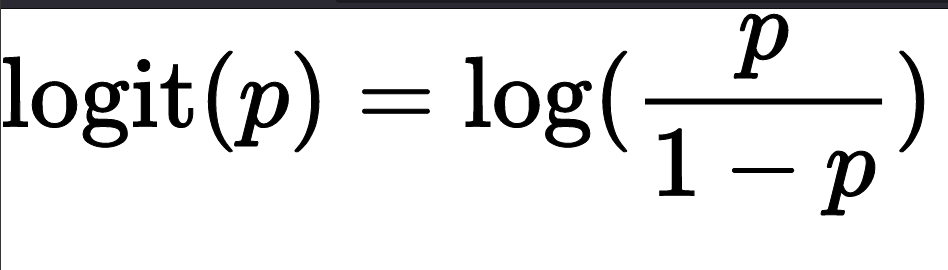

p is probability and 1-p  is corresponding odds

* In our example p = 0.5 so log(0.5/0.5) = 0; base model output is 0

* Now to get output for any point, we will
    we will add both model results(here base model gives  0, and decision tree for a specific case will give some similarity matrix):
       
    * σ((base_mode_output + α(decision tree similarity weight))
    * σ is sigmoid function, α is learning rate, which is always between 0 and 1
    * If we take α = 1 and let' say decision tree similarity weight for current row is 1
    * Then σ(0+0.1(1)) = σ(0.1)
    * Now this 0.1 will be given to sigmoid function, sigmoid function:

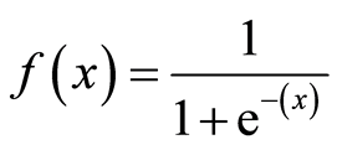

* 1/1+e^-0.1 =  0.52
* This will be our new probability for given record.
* Like this we can calculate new probability for each record. And based on this new probabilty we will calculate residuals.


In [4]:
# Let's assume these are our new probabilties
prob = [0.52, 0.56, 0.6, 0.51, 0.59]
df['new_prob'] = prob
df


,Salary,Credit_score,Approval,residual,new_prob
0,<=50K,Good,1,0.5,0.52
1,<=50K,Bad,0,-0.5,0.56
2,>=50K,Bad,0,-0.5,0.60
3,>=50K,Good,1,0.5,0.51
4,>=50K,Normal,1,0.5,0.59


In [5]:
# Then again we can calculate residuals
df["residual_new"] = df["Approval"] - df["new_prob"]
df

,Salary,Credit_score,Approval,residual,new_prob,residual_new
0,<=50K,Good,1,0.5,0.52,0.48
1,<=50K,Bad,0,-0.5,0.56,-0.56
2,>=50K,Bad,0,-0.5,0.60,-0.60
3,>=50K,Good,1,0.5,0.51,0.49
4,>=50K,Normal,1,0.5,0.59,0.41


* Now based on this residual, we will create our new decision tree using same process and step.
* But formula to get probability at the end will be updated:
    * σ((base_mode_output + α(decision_tree_1 similarity weight) + α(decision_tree_2 similarity weight))
* So generalized formula for n trees can be:
    
        σ((base_mode_output + α(T1) + α(T2) + .... α(Tn))
* After some iteration probability will be giving good value where residual will be very very less. Then we can say that our XgBoost has been trained in proper way.